# Checksum Error Detection Probability

## Formulation

Parameters are defined as follows:
- the probability with which a bit is altered is shown by $p$.
- *the size of a segment* is denoted as $n$.
- *lines of UDP segment sent from the sender*: $Lines$ that is a binary ($n \times 32$) matrix.
- *lines of UDP segment received at the receiver*: $Lines'$ that is again a binary ($n \times 32$) matrix.

Based on $Lines$ and $Lines'$, we can define $Fields$ and $Fields'$ the following way:
$$
    Fields[i, 1:16] = \begin{cases}
        Lines[k,1:16] &; i = 2k + 1 \\
        Lines[k,17:32] &; i = 2k
    \end{cases}
$$

$$
    Fields'[i, 1:16] = \begin{cases}
        Lines'[k,1:16] &; i = 2k + 1 \\
        Lines'[k,17:32] &; i = 2k
    \end{cases}
$$

We know:
- $Fields[1]$ and $Fields[2]$ represent *source port number* and *destination port number* respectively.
- $Fields[3]$ demonstrates $n$.
- $Fields[4]$ is the *checksum error* that causes:
$$
    \sum_{i=1}^{2n} Field[i] = 0
$$
where this zero in 1's complement binary representation is shown by $1_{16}$ or $0_{16}$.

The same allocations could be done similarly for $Fields'$ as well.

### The Goal

The goal of this notebook is to calculate the following probability:
$$
    Pr(\text{Undetected error}) = Pr(\sum_{i=1}^{2n} Fields'[i] = 0) - Pr(\text{No alteration})
$$

Now, if we define:
$$ \Delta[i] := Fields'[i] - Fields[i] $$
the following will be true:
$$ \sum_{i=1}^{2n} Fields'[i] = 0 \longleftrightarrow \sum_{i=1}^{2n} \Delta[i] = 0

## Parameters

In [1]:
P = 0.1
N = 100
M = 2 ** 16 - 1

## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Definition of `f[n, k]`
$$ \tag{1}
    f[n, k]: \text{chance of } \sum_{i = 1}^{2n} \Delta[i] = k
$$

## Equation
$$ \tag{2}
    \forall j \in [1, n): f[n, k] = \sum_{x = 0}^{2^{16} - 2} f[j, x]f[n - j, k - x]
$$

In [3]:
f = np.zeros((N, M), dtype=np.float128)
f

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float128)

In [4]:
binary = np.fromfunction(lambda x: x, (M + 1, ), dtype=np.uint16)
binary_repr = np.vectorize(np.binary_repr, otypes=[str])
binary = np.char.count(binary_repr(binary), '1')
print(binary)
prob = np.array((P ** binary) * ((1-P)**(16 - binary)), dtype=np.float128)
f[0] = prob[:-1]
f[0, 0] += prob[-1]
f

[ 0  1  1 ... 15 15 16]


array([[1.85302019e-01, 2.05891132e-02, 2.05891132e-02, ...,
        8.10000000e-15, 9.00000000e-16, 9.00000000e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float128)

In [5]:
calculated = np.zeros(N, dtype=np.bool_)
calculated[0] = True
calculated

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [6]:
def calc(n):
    if calculated[n - 1]:
        return
    j = -1
    for i in range(1, int((n + 1) / 2)):
        if calculated[i - 1] and calculated[n - i - 1]:
            j = i
            break
    if j == -1:
        j = int(n / 2)
        calc(j)
        calc(n - j)
    
    convolved = np.convolve(f[j - 1], f[n - j - 1])
    f[n - 1] = convolved[:M] + np.concatenate([convolved[M:], np.array([0])])
    calculated[n - 1] = True

In [7]:
calc(N)
f

array([[1.85302019e-01, 2.05891132e-02, 2.05891132e-02, ...,
        8.10000000e-15, 9.00000000e-16, 9.00000000e-16],
       [3.43368382e-02, 8.17543767e-03, 8.17543767e-03, ...,
        2.63595217e-11, 5.78623648e-12, 5.78623648e-12],
       [6.36268562e-03, 2.47513458e-03, 2.47513458e-03, ...,
        1.84807415e-09, 6.04184754e-10, 6.04184754e-10],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.52590219e-05, 1.52590219e-05, 1.52590219e-05, ...,
        1.52590219e-05, 1.52590219e-05, 1.52590219e-05]], dtype=float128)

In [8]:
np.arange(1, N + 1)[calculated]

array([  1,   2,   3,   6,  12,  13,  25,  50, 100])

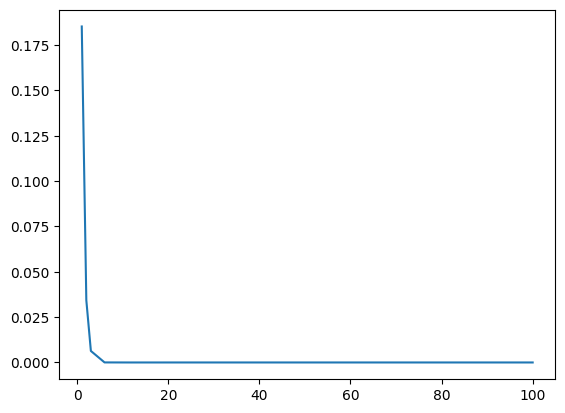

In [11]:
fig, ax = plt.subplots()
X = np.arange(1, N + 1)[calculated]
Y = f[calculated, 0]
ax.plot(X, Y)
# ax.set_xticks(np.arange(1, N + 1)[calculated])
plt.show()

## Calculating the Probability

In [10]:
p = f[N - 1, 0] - (1 - P) ** (16 * N)
print(f'The probability is {p:.10f}')

The probability is 0.0000152590
